In [1]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import numpy as np
from utils import * 
from training_utils import *

In [2]:
img_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to 224x224
    transforms.RandomRotation(degrees=10),  # Randomly rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Randomly changes brightness, contrast, and saturation
    transforms.RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust the sharpness
    transforms.ToTensor(),  # Convert the PIL Image to a PyTorch tensor
    
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor()
])


# root_dir = 'cls_training_data_by_vid'
# dataset = datasets.ImageFolder(root=root_dir)
# # check class balance
# class_names = dataset.classes

# class_count = {}
# for i in range(len(class_names)):
#     class_count[class_names[i]] = 0
# for img, label in dataset:
#     class_count[class_names[label]] += 1
# print(class_count)

# train_size = int(0.7 * len(dataset))
# val_size = int(0.2 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# train_dataset.dataset.transform = train_transforms
# valid_dataset.dataset.transform = val_test_transforms
# test_dataset.dataset.transform = val_test_transforms

batch_size = 128

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataset = datasets.ImageFolder(root='classification_dataset_groupby_env_split/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(root='classification_dataset_groupby_env_split/val', transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root='classification_dataset_groupby_env_split/test', transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

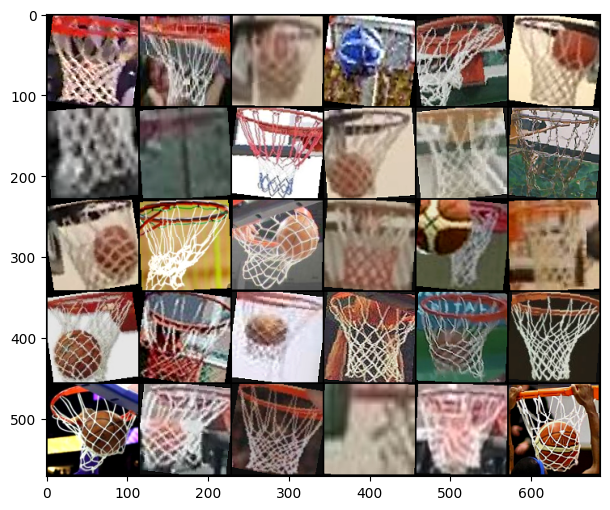

In [16]:
def imshow(img, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def visualize_transform(train_transforms = train_transforms, root_dir = None, subset_size = 30 ):
    subset_dataset = datasets.ImageFolder(root=root_dir, transform=train_transforms)

    # Select 30 random images from the subset
    subset_size = 30  # Number of images to display
    subset_indices = torch.randperm(len(subset_dataset))[:subset_size]

    # Using Subset to create a smaller dataset
    visualize_subset = torch.utils.data.Subset(subset_dataset, subset_indices)

    # DataLoader for the subset
    visualize_loader = DataLoader(visualize_subset, batch_size=subset_size, shuffle=False)

    # Retrieve the images from the loader
    images_transformed, _ = next(iter(visualize_loader))

    # Convert the images to a grid
    images_grid = torchvision.utils.make_grid(images_transformed, nrow=6, padding=2)
    imshow(images_grid)
visualize_transform(root_dir="classification_dataset_groupby_env_split/train")

In [4]:
def get_data_loaders(batch_size, img_size, root_dir = None):
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # Resize the images to 224x224
        transforms.RandomRotation(degrees=10),  # Randomly rotate images by up to 15 degrees
        transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Randomly changes brightness, contrast, and saturation
        transforms.RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust the sharpness
        transforms.ToTensor(),  # Convert the PIL Image to a PyTorch tensor
        
    ])

    val_test_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),  
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.ImageFolder(root=root_dir + '/train', transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=root_dir + '/val', transform=val_test_transforms)
    test_dataset = datasets.ImageFolder(root=root_dir + '/test', transform=val_test_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, valid_loader, test_loader

def train_epoch(model, optimizer, criterion, train_loader, device=None):
    device = device or torch.device("cpu")
    model.train()

    train_loss = 0.0
    correct_predictions = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        prob = torch.sigmoid(outputs.data)
        predicted = prob > 0.5
        correct_predictions += (predicted == targets).sum().item()
        
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_predictions / len(train_loader.dataset)
        
    return train_loss, train_accuracy
        
def test(model, criterion, valid_loader, device = None):
    correct_predictions = 0
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets)
            prob = torch.sigmoid(outputs.data)
            predicted = prob > 0.5
            correct_predictions += (predicted == targets).sum().item()
            
    test_accuracy = correct_predictions / len(valid_loader.dataset)
    test_loss /= len(valid_loader.dataset)
    
    return test_loss, test_accuracy
            

def train(config, 
          root_data_dir,
          num_epochs=10, 
          chkpt_interval=5, 
          checkpoint_dir='./cls_chkpoint', 
          early_stopping_patience=3, 
          resume_checkpoint_path=None, 
          device = "cuda",
          model_type = "resnet18",
          ):
    
    now = datetime.datetime.now()
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if model_type == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    if model_type == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.to(device)
    train_loader, valid_loader, test_loader = get_data_loaders(config["batch_size"], config["img_size"], root_data_dir)
    
    if config["optimizer"] == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config['momentum'], nesterov=config["nestrov"])
    elif config["optimizer"] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=config["lr"])
    else:
        raise ValueError(f"Invalid optimizer {config['optimizer']}")
    
    
    now = datetime.datetime.now()
    chkpoint_name = f"batch{config['batch_size']}_lr{config['lr']}_optimizer_{config['optimizer']}_imgsize{config['img_size']}"
    checkpoint_dir = os.path.join(checkpoint_dir, now.strftime('checkpoint_%Y-%m-%d-%H-%M') + "_" + chkpoint_name)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    start_epoch = 0
    best_accuracy = 0.0
    best_loss = float('inf')
    early_stopping_counter = 0

    # Resume from a checkpoint if provided
    if resume_checkpoint_path and os.path.isfile(resume_checkpoint_path):
        checkpoint = torch.load(resume_checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        best_accuracy = checkpoint.get('best_accuracy', best_accuracy)
        best_loss = checkpoint.get('best_loss', best_loss)
        losses = np.append(checkpoint['train_loss'], np.empty(num_epochs - len(checkpoint['train_loss'])))
        test_losses = np.append(checkpoint['val_loss'], np.empty(num_epochs - len(checkpoint['val_loss'])))
        train_accuracies = np.append(checkpoint['train_acc'], np.empty(num_epochs - len(checkpoint['train_acc'])))
        test_accuracies = np.append(checkpoint['val_acc'], np.empty(num_epochs - len(checkpoint['val_acc'])))
    else:
        # Initialize arrays to track the losses and accuracies
        losses = np.empty(num_epochs)
        test_losses = np.empty(num_epochs)
        train_accuracies = np.empty(num_epochs)
        test_accuracies = np.empty(num_epochs)
    
    criterion = nn.BCEWithLogitsLoss()
    if "scheduler_config" in config:
        scheduler = optim.lr_scheduler.StepLR(optimizer, **config["scheduler_config"])
        print(f"Using scheduler: {scheduler} with config: {config['scheduler_config']}") 
    else:
        scheduler = None
    
    for epoch in range(start_epoch, num_epochs):
        temp = time.time()
        train_loss, train_accuracy = train_epoch(model, optimizer, criterion, train_loader, device)
        test_loss, test_accuracy = test(model, criterion, valid_loader, device)
        
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step()
            new_lr = optimizer.param_groups[0]['lr']
            if old_lr != new_lr:
                print(f"Learning rate changed from {old_lr} to {new_lr}")
                
        losses[epoch] = train_loss
        train_accuracies[epoch] = train_accuracy
        test_accuracies[epoch] = test_accuracy
        test_losses[epoch] = test_loss
        
        # Save checkpoint after every epoch
        if (epoch + 1) % chkpt_interval == 0:
            checkpoint = {
               'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss': losses[:epoch+1],
                'train_acc': train_accuracies[:epoch+1],
                'val_loss': test_losses[:epoch+1],
                'val_acc': test_accuracies[:epoch+1]
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save(checkpoint, checkpoint_path)
        
        # Save the best model if test accuracy has improved
        if test_accuracies[epoch] > best_accuracy:
            best_accuracy = test_accuracies[epoch]
            best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
        
        # Print statistics
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"Ep[{epoch+1}/{num_epochs}]  [train loss]: {train_loss:.4f}  "
                  f"[Val Loss]: {test_loss:.4f}  "
                  f"[Best Loss]: {best_loss:.4f}  [TestAcc]: {test_accuracy:.4f}  "
                  f"[Time]: {(time.time() - temp):.2f}")
    
        history = {
            'train_loss': losses[:epoch+1].tolist(),
            'train_acc': train_accuracies[:epoch+1].tolist(),
            'val_loss': test_losses[:epoch+1].tolist(),
            'val_acc': test_accuracies[:epoch+1].tolist()
        }
        # save history to checkpoint_dir as json
        with open(os.path.join(checkpoint_dir, 'history.json'), 'w') as f:
            json.dump(history, f)
            
        # Early stopping check
        if test_losses[epoch] < best_loss:
            best_loss = test_losses[epoch]
            early_stopping_counter = 0  # reset the early stopping counter if the validation loss improves
        else:
            early_stopping_counter += 1  # increment the counter if the validation loss does not improve
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Validation loss did not improve for {early_stopping_patience} consecutive epochs.")
            break
    
    return model, history, test_loader

In [17]:
config = {
    'lr': 0.003,
    'batch_size': 128,
    'optimizer': 'sgd',
    'img_size': 224,
    'nestrov': True,
    'momentum': 0.8,
    # 'scheduler_config': {
    #     'step_size': 40,
    #     'gamma': 0.5
    # }
 }


model, history, test_loader = train(config, 
                                    num_epochs=150, 
                                    chkpt_interval=5, 
                                    checkpoint_dir='./cls_chkpoint_resnet18', 
                                    early_stopping_patience=20, 
                                    resume_checkpoint_path=None, 
                                    device = "cuda:0",
                                    model_type = "resnet18",
                                    root_data_dir = "classification_dataset_groupby_env_split"
                                    )

Ep[1/150]  [train loss]: 0.0051  [Val Loss]: 0.0056  [Best Loss]: inf  [TestAcc]: 0.7206  [Time]: 3.66
Ep[2/150]  [train loss]: 0.0044  [Val Loss]: 0.0054  [Best Loss]: 0.0056  [TestAcc]: 0.7598  [Time]: 3.74
Ep[4/150]  [train loss]: 0.0033  [Val Loss]: 0.0049  [Best Loss]: 0.0053  [TestAcc]: 0.8382  [Time]: 3.49
Ep[6/150]  [train loss]: 0.0025  [Val Loss]: 0.0038  [Best Loss]: 0.0042  [TestAcc]: 0.8725  [Time]: 3.62
Ep[8/150]  [train loss]: 0.0019  [Val Loss]: 0.0034  [Best Loss]: 0.0037  [TestAcc]: 0.8775  [Time]: 3.42
Ep[10/150]  [train loss]: 0.0015  [Val Loss]: 0.0031  [Best Loss]: 0.0030  [TestAcc]: 0.8873  [Time]: 6.74
Ep[12/150]  [train loss]: 0.0012  [Val Loss]: 0.0028  [Best Loss]: 0.0027  [TestAcc]: 0.8873  [Time]: 3.35
Ep[14/150]  [train loss]: 0.0010  [Val Loss]: 0.0027  [Best Loss]: 0.0027  [TestAcc]: 0.9020  [Time]: 3.54
Ep[16/150]  [train loss]: 0.0009  [Val Loss]: 0.0028  [Best Loss]: 0.0027  [TestAcc]: 0.8971  [Time]: 3.41
Ep[18/150]  [train loss]: 0.0007  [Val Loss]:

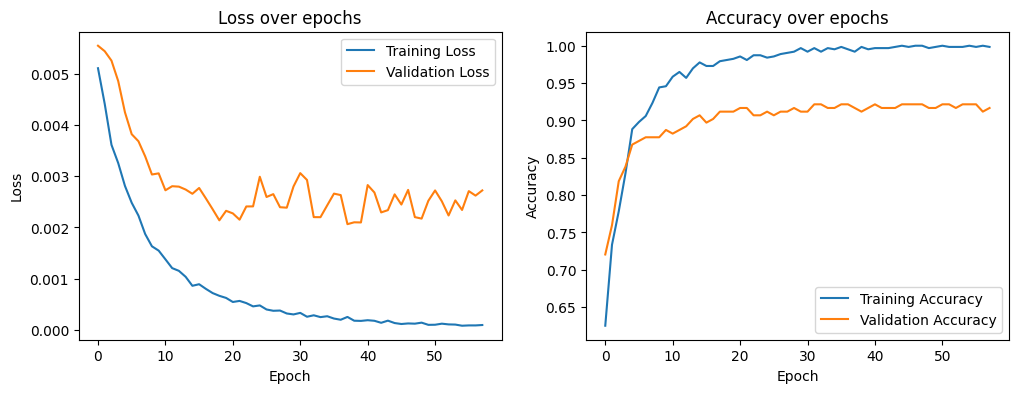

In [18]:
#plot_training_history(0, "cls_chkpoint_resnet18/checkpoint_2023-12-24-15-10_lr_0.0001_batch_64/history.json")
plot_training_history(history)

# Testing models

In [30]:
def plot_PR_curve(model, test_loader, device = "cuda:0"):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Range of thresholds to evaluate
    thresholds = np.linspace(0.05, 0.95, 1000)

    # Metrics
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        # Make predictions based on the threshold
        predicted = (np.array(all_probs) >= threshold)

        # Calculate metrics
        accuracies.append(accuracy_score(all_labels, predicted))
        precisions.append(precision_score(all_labels, predicted, zero_division=0))
        recalls.append(recall_score(all_labels, predicted, zero_division=0))
        f1_scores.append(f1_score(all_labels, predicted, zero_division=0))
    

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.title('Metrics vs Decision Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    return all_probs, all_labels
def plot_confusion_matrix(all_probs, all_labels, threshold=0.5):

    predicted = (np.array(all_probs) >= threshold)
    confusion_matrix_df = confusion_matrix(all_labels, predicted)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


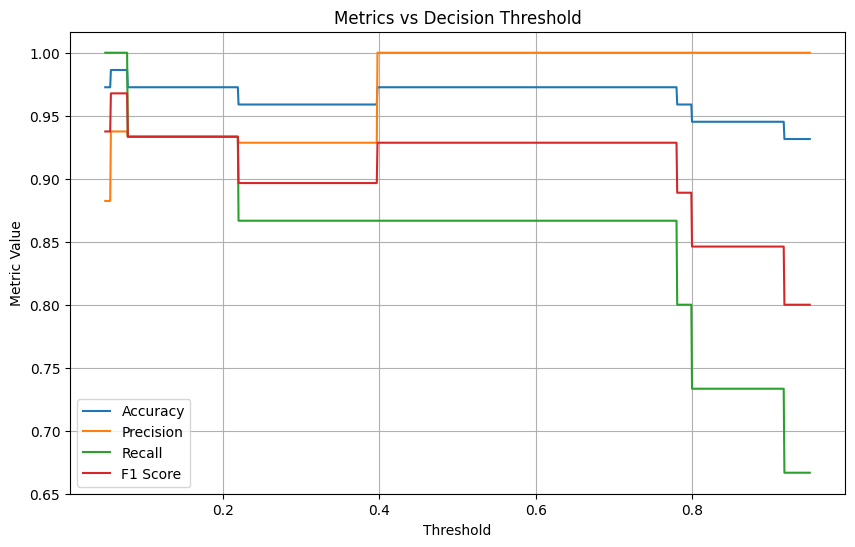

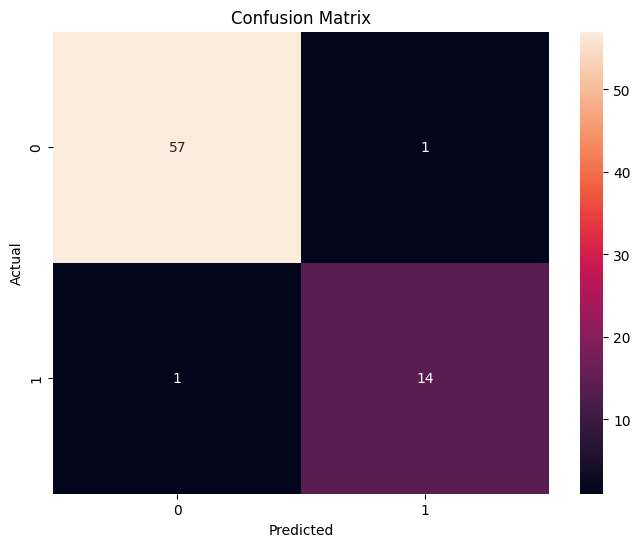

In [33]:
#model = load_resnet18("cls_chkpoint_resnet18/checkpoint_2023-12-27-13-24_batch128_lr0.0001_optimizerrmsprop_imgsize224/checkpoint_epoch_15.pth", 1)
all_probs, all_labels = plot_PR_curve(model, test_loader)
plot_confusion_matrix(all_probs, all_labels, threshold=0.2)

In [14]:


def show_feature_map(model, image_path, device = "cuda"):
    img = Image.open(image_path)

    feature_maps = []

    def hook_function(module, input, output):
        feature_maps.append(output)

    # Register the hook to the first convolutional layer of the first block of layer1
    hook = model.layer1[0].conv1.register_forward_hook(hook_function)

    # Load an image


    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
    ])
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        _ = model(img_tensor)

    # Unregister the hook
    hook.remove()

    # Visualize the feature maps
    fm = feature_maps[0].squeeze(0)  # Get the feature maps

    # Plotting
    fig, axes = plt.subplots(8, 8, figsize=(20, 20))  # Adjust subplot dimensions as needed
    for i, ax in enumerate(axes.flat):
        if i < 64:  # Adjust this based on how many feature maps you want to visualize
            ax.imshow(fm[i].detach().cpu().numpy(), cmap='viridis')
            ax.axis('off')
    plt.tight_layout()
    plt.show()





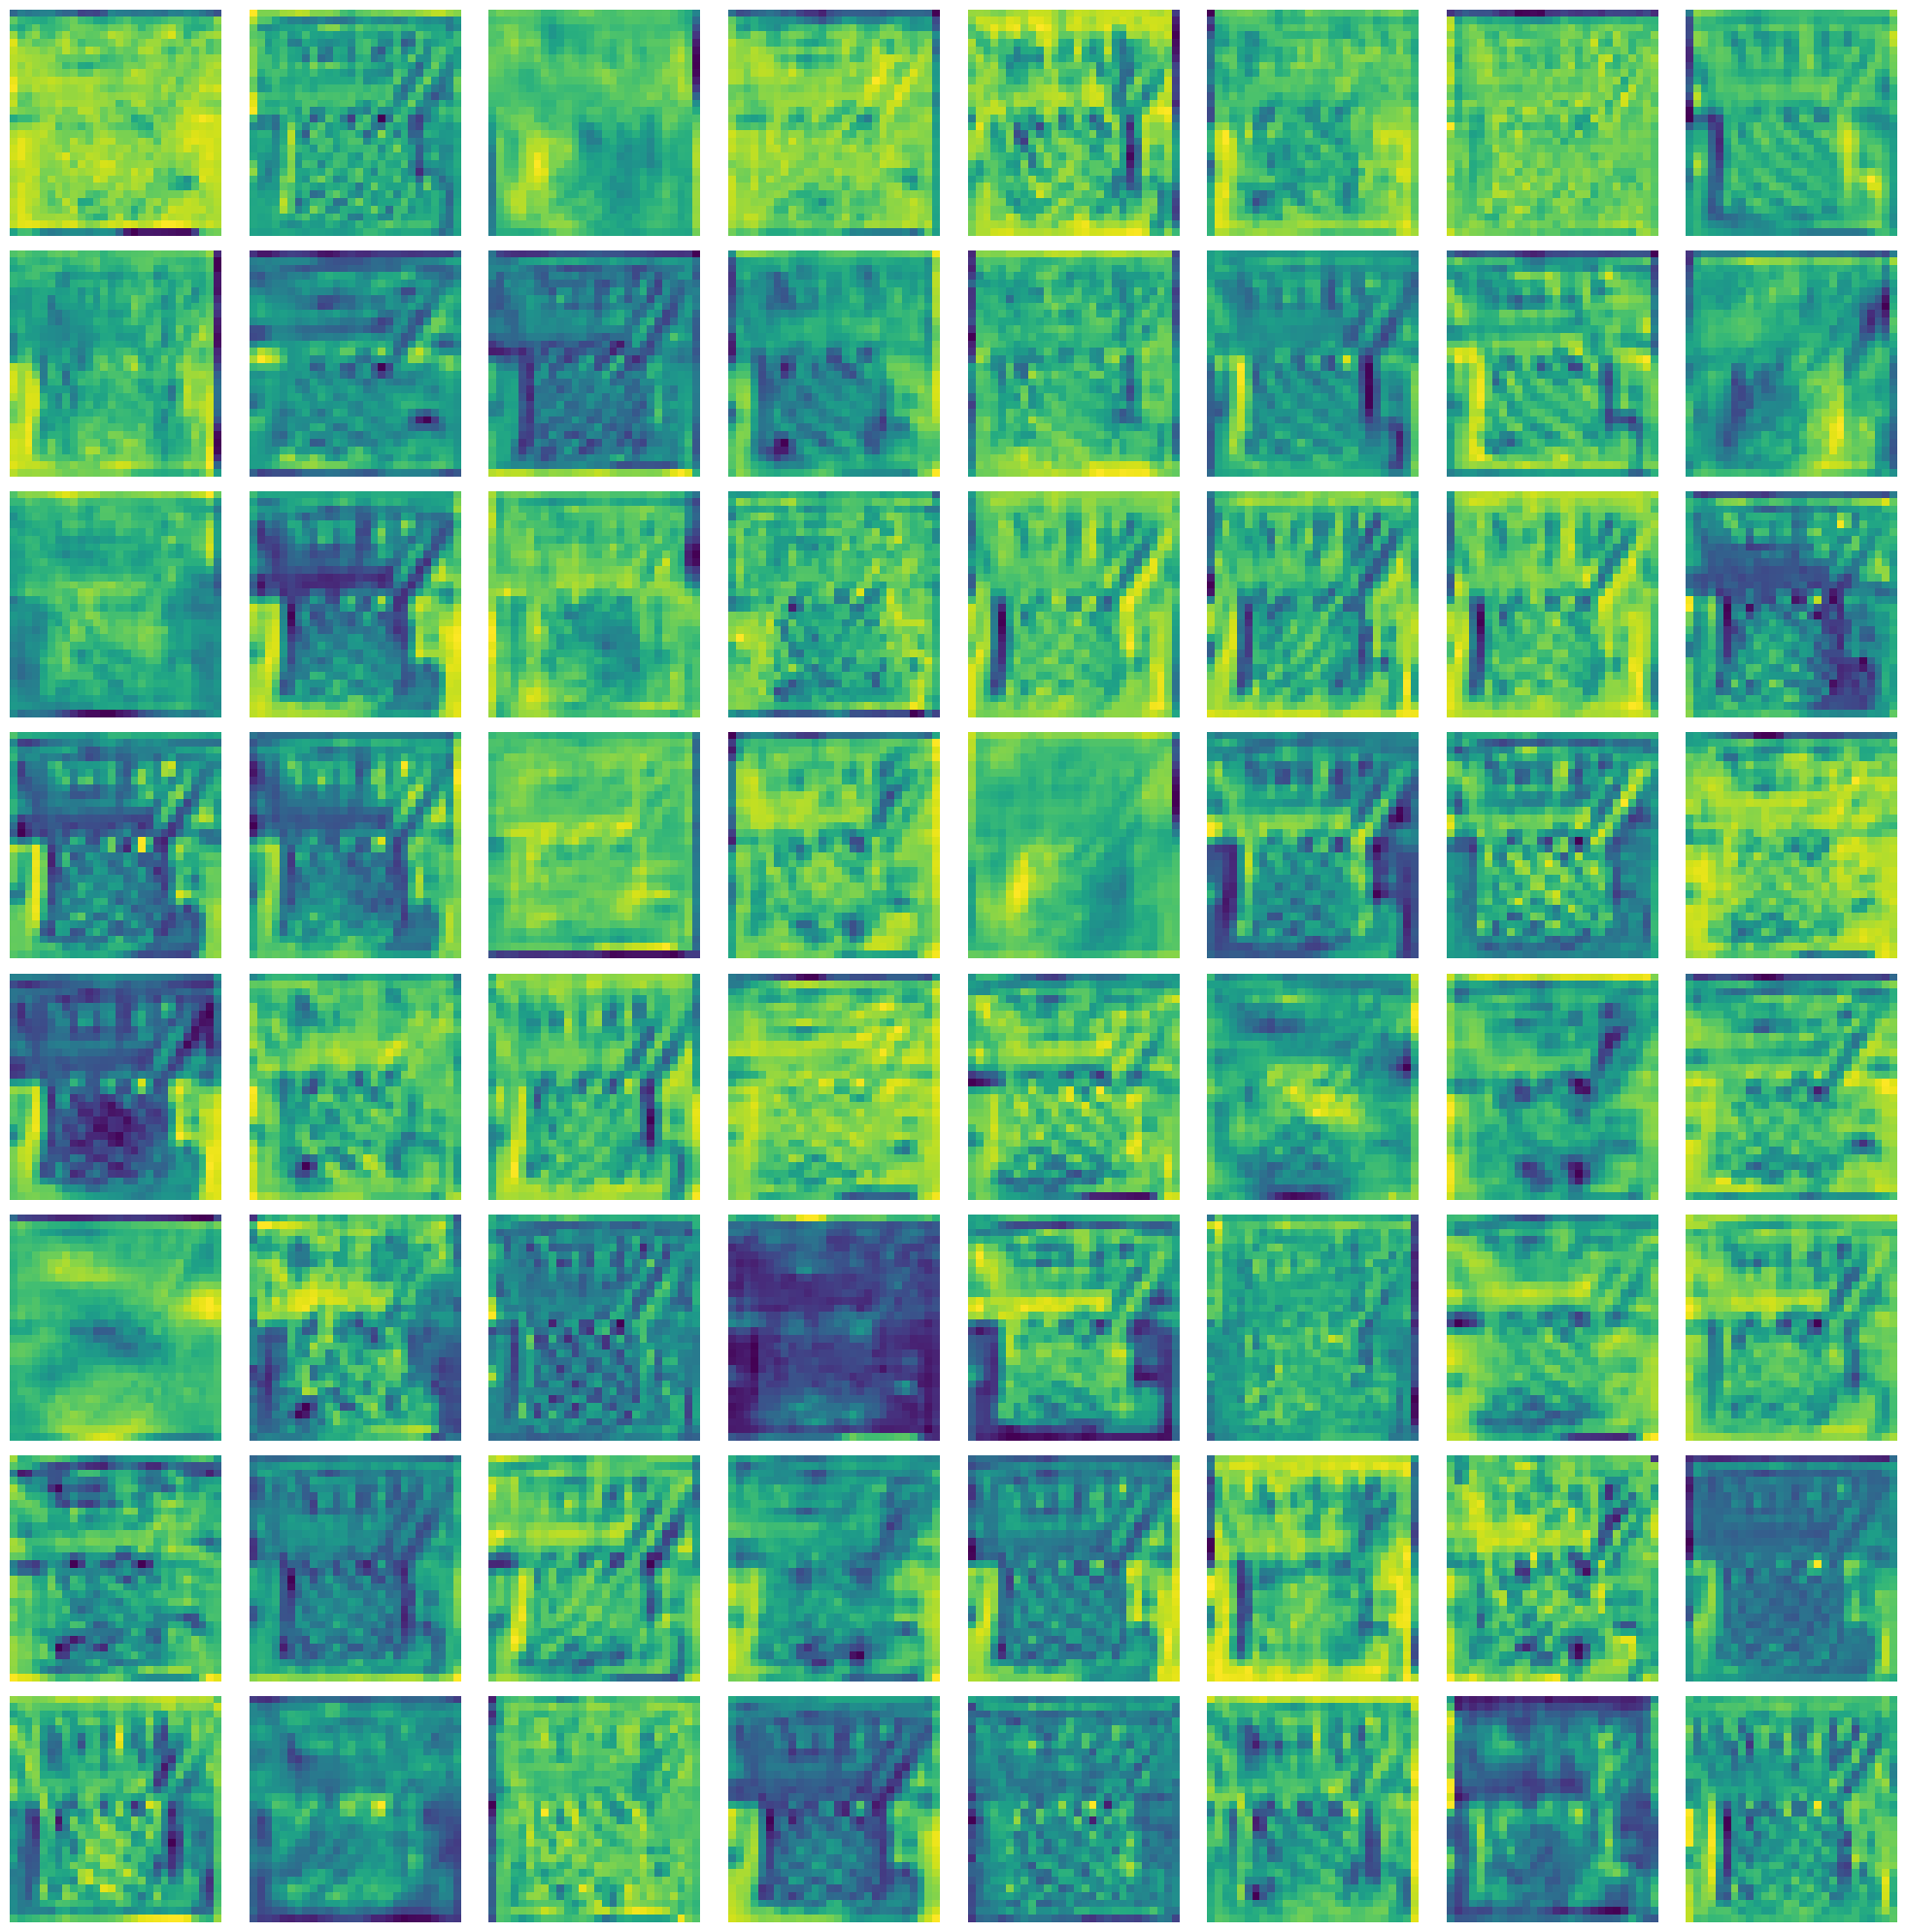

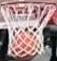

In [15]:
show_feature_map(model, 'classification_dataset/1/12_jpg.rf.9e8ec52c88bc5a65e52a1dfd471005af.jpg' )
Image.open('classification_dataset/1/12_jpg.rf.9e8ec52c88bc5a65e52a1dfd471005af.jpg')

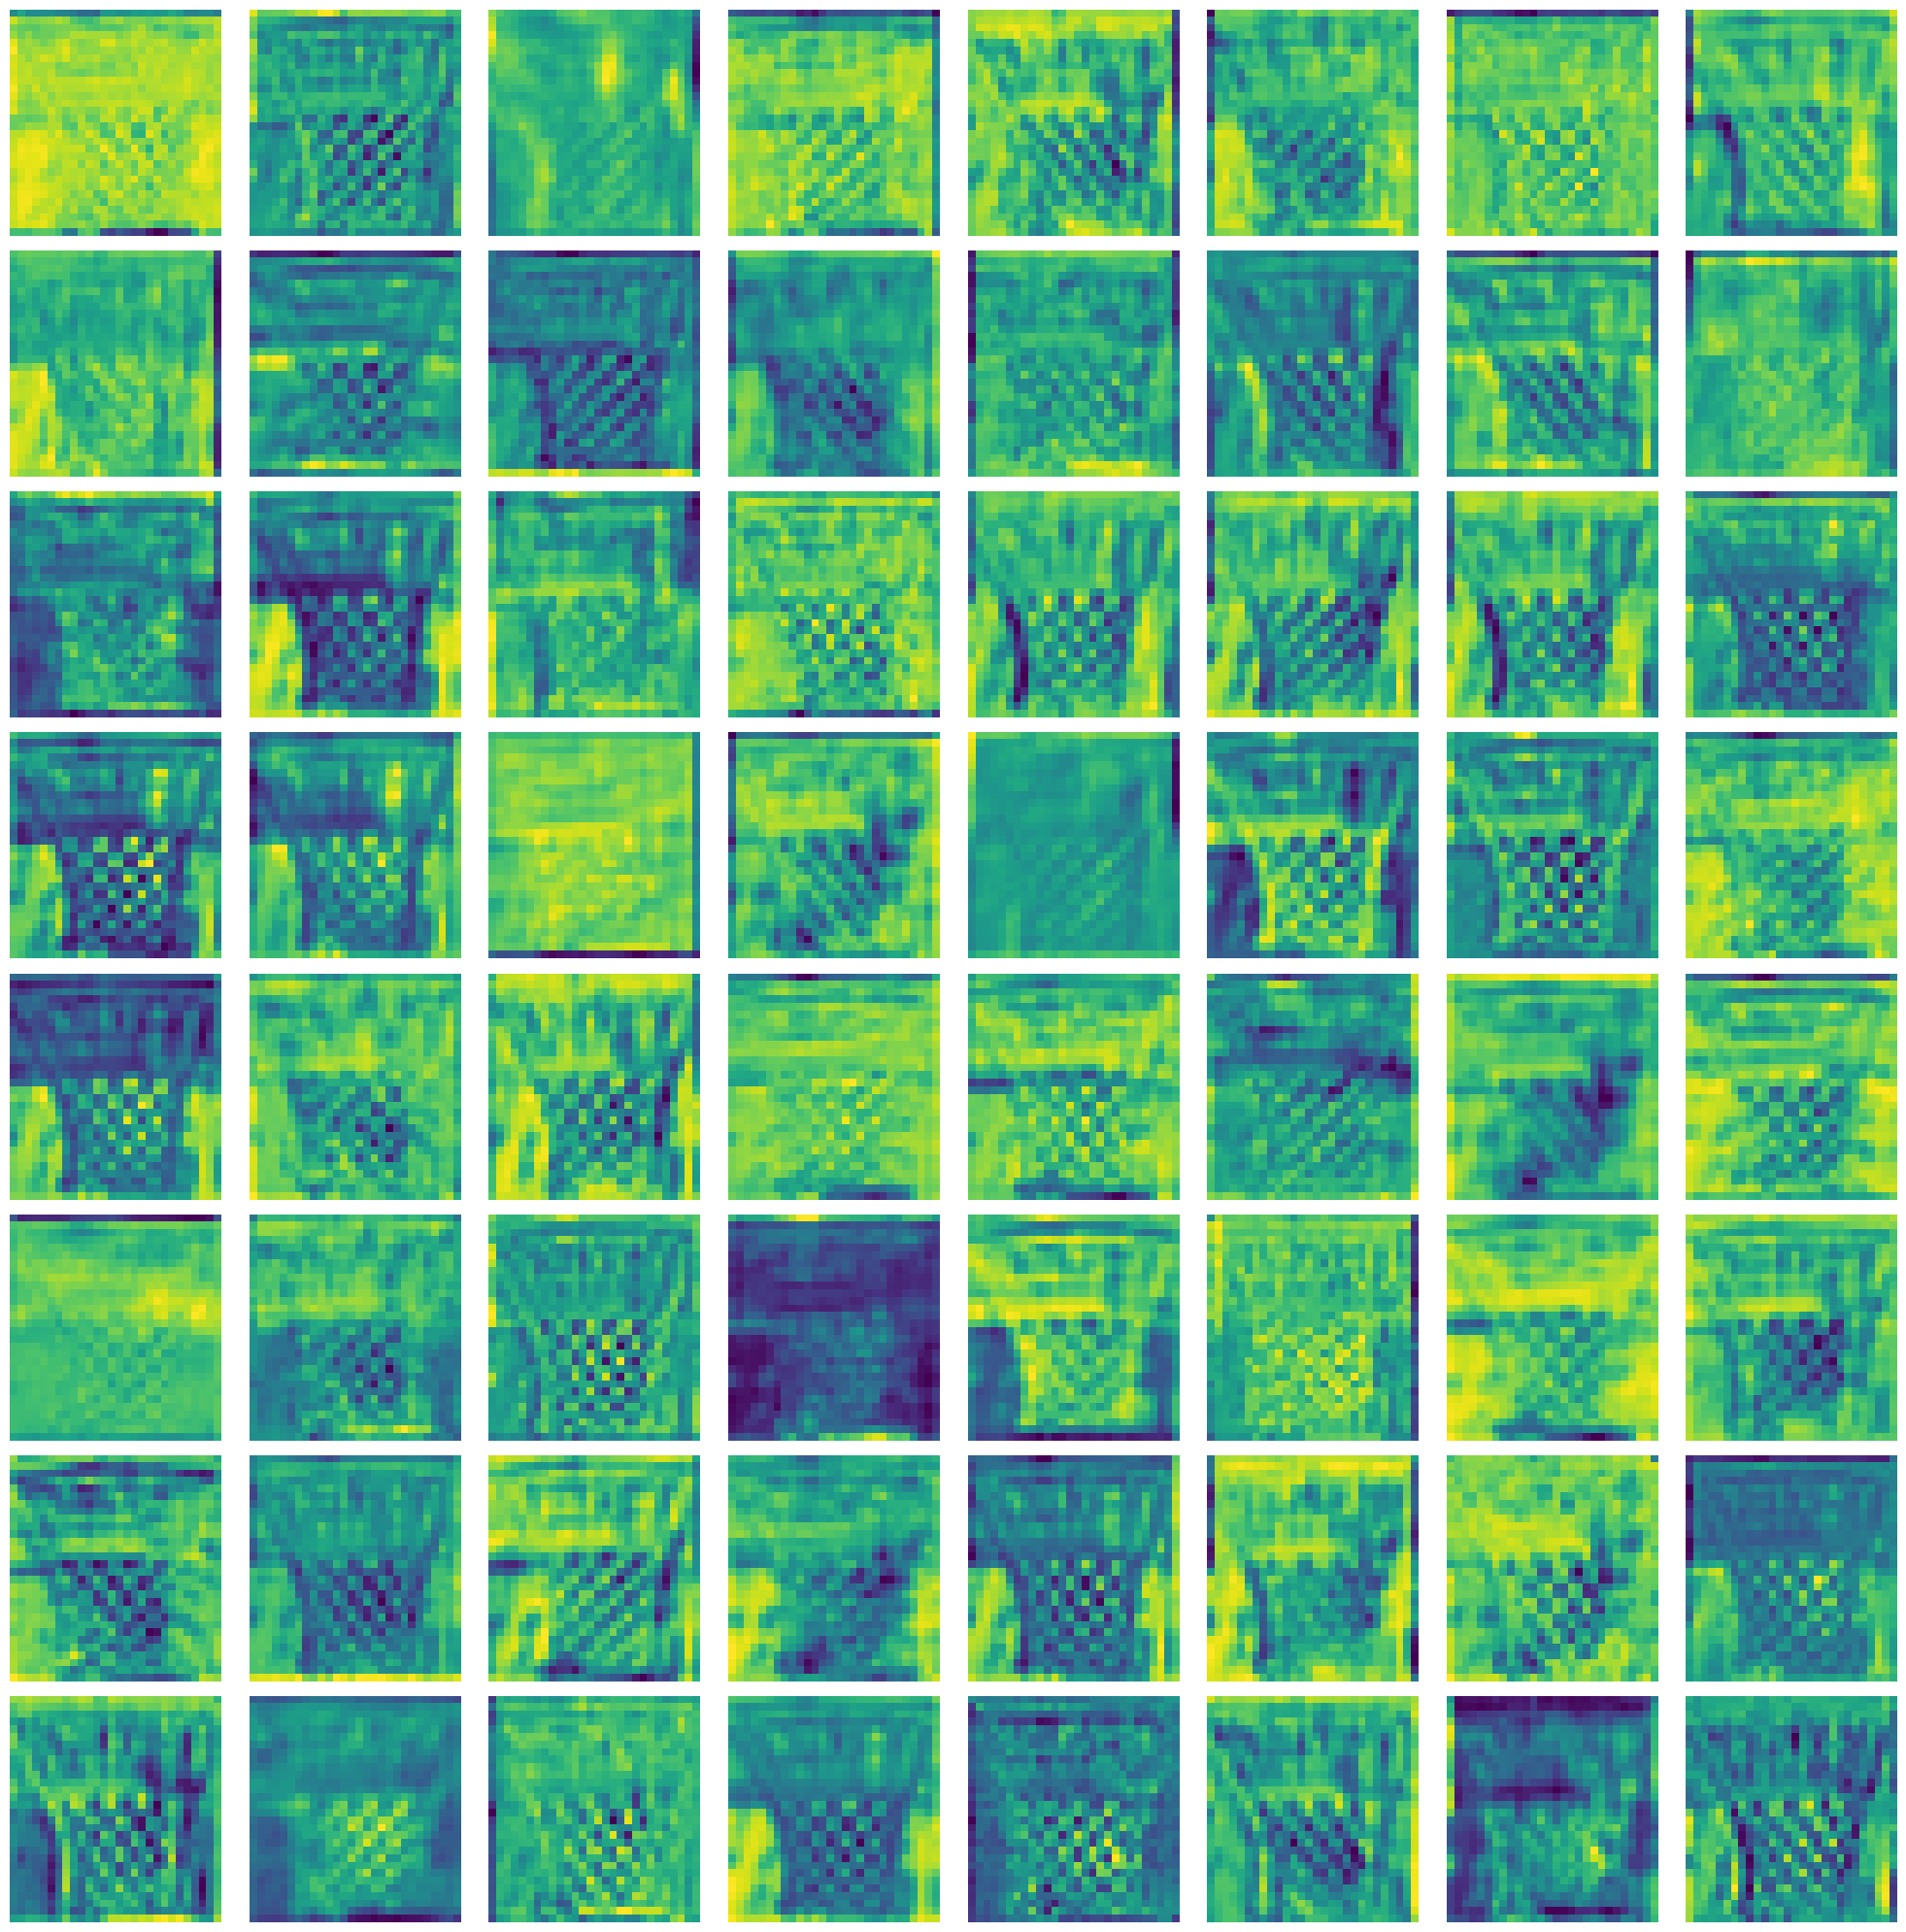

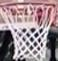

In [16]:
show_feature_map(model, "classification_dataset/0/2-2_1_2_jpg.rf.515dea5e560418ca448a1d82c435799d.jpg")
# display the image
Image.open("classification_dataset/0/2-2_1_2_jpg.rf.515dea5e560418ca448a1d82c435799d.jpg")

# Tuning Hyperparams


In [20]:
import ray
from ray import tune
from ray.tune.schedulers import HyperBandScheduler
from training_utils import *

In [21]:
data_full_path = "/scratch/zw2688/DL_project/classification_dataset_groupby_env_split"       
def train_resnet(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.to(device)
    train_loader, valid_loader, _ = get_data_loaders(config["batch_size"], config["img_size"],  data_full_path)
    
    if config["optimizer"] == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config['momentum'], nesterov=config["nestrov"])
    elif config["optimizer"] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=config["lr"])

    criterion = nn.BCEWithLogitsLoss()
    while True:
        train_epoch(model, optimizer, criterion, train_loader, device)
        _, test_accuracy = test(model, criterion, valid_loader, device)
        ray.train.report(metrics = {"accuracy": test_accuracy})
 

In [23]:
   
    
batch_sizes = [64, 128, 256]
img_sizes = [224, 112, 96]
optimizers = ["sgd", "rmsprop", "adam"]

# hyperband
hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=81,
    reduction_factor=3)

hyperband_analysis = tune.run(
    train_resnet,
    name="tuning_cls_resnet18",
    stop={
        "accuracy": 0.9,
        "training_iteration": 100
    },
    resources_per_trial={
        "gpu": 0.5,
        "cpu": 2
    },
    config={
        "lr": tune.loguniform(5e-5, 5e-3),
        "batch_size": tune.grid_search(batch_sizes),
        "optimizer": tune.grid_search(optimizers),
        "img_size": tune.grid_search([224, 112, 96]),
        "nestrov": tune.grid_search([True, False]),
        "momentum": tune.grid_search([0.9, 0.8, 0.7]),
    },
    scheduler=hyperband_scheduler,
    resume = True
    )

2023-12-27 12:20:38,416	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2023-12-27 12:20:38,438	WARNING tune_controller.py:407 -- Attempting to resume experiment from /home/zw2688/ray_results/tuning_cls_resnet18. This will ignore any new changes to the specification.
2023-12-27 12:20:38,440	INFO tune_controller.py:411 -- Using the newest experiment state file found within the experiment directory: experiment_state-2023-12-27_11-44-14.json


Trial name,accuracy
train_resnet_fe034_00000,0.931373
train_resnet_fe034_00001,0.887255
train_resnet_fe034_00002,0.720588
train_resnet_fe034_00003,0.759804
train_resnet_fe034_00004,0.906863
train_resnet_fe034_00005,0.789216
train_resnet_fe034_00010,0.720588
train_resnet_fe034_00016,0.740196
train_resnet_fe034_00019,0.70098
train_resnet_fe034_00034,0.897059


2023-12-27 13:11:24,161	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-12-27 13:11:34,608	ERROR tune.py:1043 -- Trials did not complete: [train_resnet_fe034_00034, train_resnet_fe034_00016]
2023-12-27 13:11:34,611	INFO tune.py:1047 -- Total run time: 3056.20 seconds (3045.65 seconds for the tuning loop).
2023-12-27 13:11:34,612	WARNING tune.py:1062 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2023-12-27 13:11:34,662	WARNING experiment_analysis.py:185 -- Failed to fetch metrics for 54 trial(s):
- train_resnet_fe034_00000: FileNotFoundError('Could not fetch metrics for train_resnet_fe034_00000: both result.json and progress.csv were not found at /scratch/zw2688/DL_project/tune_results/tuning_cls_resnet18/train_resnet_fe034_00000_0_batch_size=64

<div class="tuneStatus">
  <div style="display: flex;flex-direction: row">
    <div style="display: flex;flex-direction: column;">
      <h3>Tune Status</h3>
      <table>
<tbody>
<tr><td>Current time:</td><td>2023-12-25 11:35:35</td></tr>
<tr><td>Running for: </td><td>00:25:00.93        </td></tr>
<tr><td>Memory:      </td><td>40.3/377.3 GiB     </td></tr>
</tbody>
</table>
    </div>
    <div class="vDivider"></div>
    <div class="systemInfo">
      <h3>System Info</h3>
      Using HyperBand: num_stopped=42 total_brackets=5<br>Round #0:<br>  Bracket(Max Size (n)=5, Milestone (r)=81, completed=27.4%): {RUNNING: 1, TERMINATED: 4} <br>  Bracket(Max Size (n)=3, Milestone (r)=81, completed=21.4%): {PAUSED: 2, TERMINATED: 6} <br>  Bracket(Max Size (n)=5, Milestone (r)=27, completed=26.3%): {PAUSED: 5, TERMINATED: 10} <br>  Bracket(Max Size (n)=12, Milestone (r)=9, completed=26.2%): {PAUSED: 9, TERMINATED: 25} <br>  Bracket(Max Size (n)=27, Milestone (r)=3, completed=17.8%): {PAUSED: 23, PENDING: 1, RUNNING: 3, TERMINATED: 19} <br>Logical resource usage: 10.0/48 CPUs, 2.5/4 GPUs (0.0/1.0 accelerator_type:RTX)
    </div>
    <div class="vDivider"></div>
<div class="messages">
  <h3>Messages</h3>
  
  ... 88 more trials not shown (31 PAUSED, 56 TERMINATED)
  
</div>
<style>
.messages {
  color: var(--jp-ui-font-color1);
  display: flex;
  flex-direction: column;
  padding-left: 1em;
  overflow-y: auto;
}
.messages h3 {
  font-weight: bold;
}
.vDivider {
  border-left-width: var(--jp-border-width);
  border-left-color: var(--jp-border-color0);
  border-left-style: solid;
  margin: 0.5em 1em 0.5em 1em;
}
</style>

  </div>
  <div class="hDivider"></div>
  <div class="trialStatus">
    <h3>Trial Status</h3>
    <table>
<thead>
<tr><th>Trial name              </th><th>status    </th><th>loc                </th><th style="text-align: right;">  batch_size</th><th style="text-align: right;">  img_size</th><th style="text-align: right;">         lr</th><th style="text-align: right;">  momentum</th><th>nestrov  </th><th>optimizer  </th><th style="text-align: right;">  iter</th><th style="text-align: right;">  total time (s)</th><th style="text-align: right;">  accuracy</th></tr>
</thead>
<tbody>
<tr><td>train_resnet_22b36_00000</td><td>RUNNING   </td><td>10.32.35.78:1758701</td><td style="text-align: right;">          32</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.00417535 </td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    15</td><td style="text-align: right;">       1493.53  </td><td style="text-align: right;">  0.833333</td></tr>
<tr><td>train_resnet_22b36_00076</td><td>RUNNING   </td><td>10.32.35.78:1769809</td><td style="text-align: right;">          64</td><td style="text-align: right;">       112</td><td style="text-align: right;">9.24398e-05</td><td style="text-align: right;">       0.7</td><td>True     </td><td>rmsprop    </td><td style="text-align: right;">     1</td><td style="text-align: right;">         28.0012</td><td style="text-align: right;">  0.666667</td></tr>
<tr><td>train_resnet_22b36_00079</td><td>RUNNING   </td><td>10.32.35.78:1770043</td><td style="text-align: right;">          64</td><td style="text-align: right;">        96</td><td style="text-align: right;">0.00455878 </td><td style="text-align: right;">       0.7</td><td>True     </td><td>rmsprop    </td><td style="text-align: right;">     1</td><td style="text-align: right;">         18.4259</td><td style="text-align: right;">  0.75    </td></tr>
<tr><td>train_resnet_22b36_00081</td><td>RUNNING   </td><td>10.32.35.78:1766260</td><td style="text-align: right;">          32</td><td style="text-align: right;">       224</td><td style="text-align: right;">9.84273e-05</td><td style="text-align: right;">       0.9</td><td>False    </td><td>rmsprop    </td><td style="text-align: right;">     1</td><td style="text-align: right;">         15.7612</td><td style="text-align: right;">  0.833333</td></tr>
<tr><td>train_resnet_22b36_00007</td><td>PAUSED    </td><td>10.32.35.78:1758708</td><td style="text-align: right;">          64</td><td style="text-align: right;">        96</td><td style="text-align: right;">7.05892e-05</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    27</td><td style="text-align: right;">         71.9149</td><td style="text-align: right;">  0.666667</td></tr>
<tr><td>train_resnet_22b36_00008</td><td>PAUSED    </td><td>10.32.35.78:1759389</td><td style="text-align: right;">         128</td><td style="text-align: right;">        96</td><td style="text-align: right;">0.000119394</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    27</td><td style="text-align: right;">         62.0868</td><td style="text-align: right;">  0.868421</td></tr>
<tr><td>train_resnet_22b36_00013</td><td>PAUSED    </td><td>10.32.35.78:1759860</td><td style="text-align: right;">          64</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.000951119</td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">        111.693 </td><td style="text-align: right;">  0.833333</td></tr>
<tr><td>train_resnet_22b36_00014</td><td>PAUSED    </td><td>10.32.35.78:1760010</td><td style="text-align: right;">         128</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.00374332 </td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">         90.1043</td><td style="text-align: right;">  0.881579</td></tr>
<tr><td>train_resnet_22b36_00016</td><td>PAUSED    </td><td>10.32.35.78:1760302</td><td style="text-align: right;">          64</td><td style="text-align: right;">        96</td><td style="text-align: right;">7.71758e-05</td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">         23.0398</td><td style="text-align: right;">  0.833333</td></tr>
<tr><td>train_resnet_22b36_00019</td><td>PAUSED    </td><td>10.32.35.78:1760554</td><td style="text-align: right;">          64</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000101113</td><td style="text-align: right;">       0.7</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">        195.414 </td><td style="text-align: right;">  0.916667</td></tr>
<tr><td>train_resnet_22b36_00027</td><td>PAUSED    </td><td>10.32.35.78:1761701</td><td style="text-align: right;">          32</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000147773</td><td style="text-align: right;">       0.9</td><td>False    </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">        190.726 </td><td style="text-align: right;">  0.916667</td></tr>
<tr><td>train_resnet_22b36_00029</td><td>PAUSED    </td><td>10.32.35.78:1768086</td><td style="text-align: right;">         128</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.00537547 </td><td style="text-align: right;">       0.9</td><td>False    </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">        167.263 </td><td style="text-align: right;">  0.921053</td></tr>
<tr><td>train_resnet_22b36_00082</td><td>PENDING   </td><td>10.32.35.78:1766317</td><td style="text-align: right;">          64</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.00144752 </td><td style="text-align: right;">       0.9</td><td>False    </td><td>rmsprop    </td><td style="text-align: right;">     1</td><td style="text-align: right;">         19.2406</td><td style="text-align: right;">  0.916667</td></tr>
<tr><td>train_resnet_22b36_00001</td><td>TERMINATED</td><td>10.32.35.78:1758702</td><td style="text-align: right;">          64</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000634793</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     6</td><td style="text-align: right;">        589.184 </td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00002</td><td>TERMINATED</td><td>10.32.35.78:1758703</td><td style="text-align: right;">         128</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000137173</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    80</td><td style="text-align: right;">       1490     </td><td style="text-align: right;">  0.881579</td></tr>
<tr><td>train_resnet_22b36_00003</td><td>TERMINATED</td><td>10.32.35.78:1758704</td><td style="text-align: right;">          32</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.000574162</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     4</td><td style="text-align: right;">        123.667 </td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00004</td><td>TERMINATED</td><td>10.32.35.78:1758705</td><td style="text-align: right;">          64</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.000252852</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    10</td><td style="text-align: right;">        112.31  </td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00005</td><td>TERMINATED</td><td>10.32.35.78:1758706</td><td style="text-align: right;">         128</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.00756926 </td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     8</td><td style="text-align: right;">         69.4052</td><td style="text-align: right;">  0.934211</td></tr>
<tr><td>train_resnet_22b36_00006</td><td>TERMINATED</td><td>10.32.35.78:1758707</td><td style="text-align: right;">          32</td><td style="text-align: right;">        96</td><td style="text-align: right;">0.00337975 </td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     3</td><td style="text-align: right;">         80.6108</td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00009</td><td>TERMINATED</td><td>10.32.35.78:1759430</td><td style="text-align: right;">          32</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000443854</td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     4</td><td style="text-align: right;">         92.9186</td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00010</td><td>TERMINATED</td><td>10.32.35.78:1759513</td><td style="text-align: right;">          64</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.00269921 </td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     8</td><td style="text-align: right;">        761.078 </td><td style="text-align: right;">  1       </td></tr>
</tbody>
</table>
  </div>
</div>
<style>
.tuneStatus {
  color: var(--jp-ui-font-color1);
}
.tuneStatus .systemInfo {
  display: flex;
  flex-direction: column;
}
.tuneStatus td {
  white-space: nowrap;
}
.tuneStatus .trialStatus {
  display: flex;
  flex-direction: column;
}
.tuneStatus h3 {
  font-weight: bold;
}
.tuneStatus .hDivider {
  border-bottom-width: var(--jp-border-width);
  border-bottom-color: var(--jp-border-color0);
  border-bottom-style: solid;
}
.tuneStatus .vDivider {
  border-left-width: var(--jp-border-width);
  border-left-color: var(--jp-border-color0);
  border-left-style: solid;
  margin: 0.5em 1em 0.5em 1em;
}
</style>


In [18]:
from ray.tune import ExperimentAnalysis

In [19]:
restore_tuner = tune.Tuner.restore("~/ray_results/tuning_cls_resnet18",
                                  trainable=train_resnet,
                                  resume_unfinished = False)

result_grid = ExperimentAnalysis("~/ray_results/tuning_cls_resnet18").fetch_trial_dataframes()

FileNotFoundError: [Errno 2] Failed to open local file '/home/zw2688/ray_results/tuning_cls_resnet18/tuner.pkl'. Detail: [errno 2] No such file or directory

In [22]:
hyperband_analysis.get_best_config(metric="accuracy", mode="max")


{'lr': 0.003496941651621201,
 'batch_size': 64,
 'optimizer': 'sgd',
 'img_size': 224,
 'nestrov': True,
 'momentum': 0.7880866514607588}